In [390]:
def game1_score(click, env_white, prior_clicks, prior_bgs):
    """"This game will be to click green boxes. Each click of a green box 
    adds points to a player's score. Each click of a red or blue box has 
    no effect on a player's score."""
    
    if click == "green":
        return 1

    return 0 
    
    
def game2_score(click, env_white, prior_clicks, prior_bgs):
    """"The objective of the game is to click the blue square as many times 
    as possible while the black background is present and to also click on 
    the green square as many times as possible while the white background 
    is present. Each of these actions results in one point being awarded. 
    However, if the blue square is clicked while the white background or if 
    the green background is clicked while the black background is present, 
    three points are docked from the score. The red square is neutral and 
    serves no purpose other than changing the background color."""
    
    if env_white:
        if click == "green":
            return 1
        else: 
            return 0 #changed to match hyp (no negative)
        
    elif not env_white:
        if click == "blue":
            return 1 
        else:
            return 0 #changed to match hypotheses
 
def game3_score(click, env_white, prior_clicks, prior_bgs):
    """"Get one point every time click any red, then any green, then any blue 
    during night. Have to click in that order. When background is white, no 
    points or penalties. Have to start from beginning of order whenever it 
    switches back to night.
    """
    
    if not env_white: 
        if click == "blue":
            if (prior_bgs[-1] == False) and (prior_clicks[-1] == "green"):
                return 1
    return 0 
 
def game4_score(click, env_white, prior_clicks, prior_bgs):
    """Have to click on blue, green, red in repeating order. Points
    are given independent of the color of the background.
    
    (Scoring changed from above specification for game plaly so only requires history of 3 clicks)
    """
    
    if click == "red":
        if (prior_clicks[-1] == "green") and (prior_clicks[-2] == "blue"):
                return 1
    
    return 0 
    

In [471]:
import numpy as np

def play_game(hypotheses, priors, game, prior_clicks, prior_bgs, env_bg_white, num_clicks, bg_change_prob=0.2):
    """
    Function that simulates game human play. Samples hypothesis from distribution with based on current prob (with 
    some noise introduced). Selects actions based on hypothesis sampled. Stops testing hypothesis as soon as 
    observed rewards are inconsistent with the hypothesis. 
    Inputs: 
    - hypotheses: categorical distribution representing all possible hypotheses and normalized priors
    - game: reward function of game to simulate reward observed when selecting different moves
    - env_bg_init: initialization of environment background (either black or white)
    - bg_change_prob: likelihood of a change in background color after each click  
    
    Future directions: explore other handicaps to make more human-like such as memory loss.
    For now keeping model the exact same as inference model w/ memory of 3 clicks.
    """

    #TO DO: introduce noise to priors when sampling a hypothesis 
    
    #Sample a hypothesis that is testable with the current background
    consistent_hyp_found = False
    
    for i in range(1000):
        sampled_hypothesis = np.random.choice(hypotheses, p=priors)
        if sampled_hypothesis['either'] or (sampled_hypothesis['white'] and env_bg_white) or (sampled_hypothesis['black'] and not env_bg_white):
            consistent_hyp_found = True
            break
    
    #Select clicks to test based on hypothesis and environment background
    if consistent_hyp_found: 
        if sampled_hypothesis['either']: 
            sampled_hypothesis_clicks = sampled_hypothesis['either']
        elif env_bg_white:
            sampled_hypothesis_clicks = sampled_hypothesis['white']
        elif not env_bg_white:
            sampled_hypothesis_clicks = sampled_hypothesis['black']  
            
    else: 
        sampled_hypothesis_clicks = ["red"]
    
    #Simulate testing the hypothesis in the game by clicking each component of hypothesis in order 
    for click in sampled_hypothesis_clicks: 
        
        num_clicks+=1
        bg_change = False
    
        #get reward after click from game scoring function
        observed_reward = game(click, env_bg_white, prior_clicks, prior_bgs)  
        
        #create evidence tuple (c1,c2,c3,bg1,bg2,bg3,reward)
        #c3 and bg3 represent the most recent click and associated background
        evidence = prior_clicks+[click]+prior_bgs+[env_bg_white]+[observed_reward]
        
        #check to see if observed reward is consistent with the hypothesis
        expected_reward = check_hypothesis(sampled_hypothesis, evidence)
        
        #Before breaking out of the loop, add the click just tested and associated background
        #to prior_clicks and prior_bgs. Only maintain a memory of 2 previous clicks (3 total)
        #as done in the original inference model.
        prior_clicks = prior_clicks[1:]+[click]
        prior_bgs = prior_bgs[1:]+[env_bg_white]
 
        #Simulate play by changing background with pre-defined probability after each click
        if np.random.random() < bg_change_prob: 
            bg_change = True
            env_bg_white = not env_bg_white

        #If observed outcome inconsistent with hypothesis, break out of loop and stop testing hypothesis
        if expected_reward != observed_reward:
          #  print('expected reward not consistent')
            break 
            
        #If background changes, make sure that player can continue to test the same hypothesis with the 
        #new background (specification defined for "either", or specification defined for both "black"
        #and "white"). If so, switch specification being tested to the one of the appropriate background. 
        #Otherwise, stop testing hypothesis and sample a new one.
        if bg_change:
            if sampled_hypothesis['either']: 
                continue   
            elif not env_bg_white:
                if not sampled_hypothesis['black']: 
                    break
                else: 
                    sampled_hypothesis_clicks = sampled_hypothesis['black']
            elif env_bg_white:
                if not sampled_hypothesis['white']:
                    break
                else: 
                    sampled_hypothesis_clicks = sampled_hypothesis['white']
    
    #update all hypotheses based on evidence
    normalized_posteriors = update_hypotheses(hypotheses, priors, evidence)
    
    #if model certain about correct hypothesis, break
    if 1 in normalized_posteriors: 
        #h= normalized_posteriors.index(1)
        #print(h)
        #print("Inferred specification:", hypotheses[h])
        #print("Number of clicks:", num_clicks)
        return num_clicks
    else: 
        num_clicks = play_game(hypotheses, normalized_posteriors, game, prior_clicks, prior_bgs, env_bg_white, num_clicks)
        return num_clicks
        
def check_hypothesis(rule, evidence):
    """Check to see if the rule's specification is defined for the background of the last click
        and that the background history of observations matches the required rule background history.
        Based on this information check to see if the expected reward matches the observed reward. 
        
        Multiple ways we could go about this such as sampling-based, right now just updating all.
        
        """
    if rule["either"]: 
        rule_length = len(rule["either"])
        expected_reward = rule["either"] == list(evidence[-4-rule_length:-4])
        return expected_reward
            
    expected_reward_black = 0 
    if rule["black"]:
        rule_length = len(rule["black"])
        if evidence[-1-rule_length:-1] == [False]*rule_length:
            expected_reward_black = rule["black"] == list(evidence[-4-rule_length:-4])
            
    expected_reward_white=0
    if rule["white"]:
        rule_length = len(rule["white"])
        if evidence[-1-rule_length:-1] == [True]*rule_length:
            expected_reward_white = rule["white"] == list(evidence[-4-rule_length:-4])
        
    return expected_reward_black or expected_reward_white

def update_hypotheses(hypotheses, priors, evidence):
    """For each remaining hypothesis, check if evidence is consistent with hypothesis or 
    not. If evidence is not consistent, set probability to zero. Normalize final set of 
    probabilities.
    
    Input: 
    - hypotheses (list of dictionaries describing each rule)
    - priors (list of priors associated to hypothesis of same index)
    - evidence (tuple of 7 values containing: the last 3 clicks, 
      the background of the last 3 clicks, and the observed reward,
      e.g. (c1=red,c2=red,c3=blue,bg1=black,bg2=black,bg3=white,r=0)  
    """
    posterior = priors.copy()
    
    for i, rule in enumerate(hypotheses):
        
        expected_reward = check_hypothesis(rule,evidence)
    
        if expected_reward != evidence[-1]:
            posterior[i]=0
    
    normalized_posteriors = [float(i)/sum(posterior) for i in posterior]
    return normalized_posteriors
        

In [472]:
hypotheses = [{'type': 2, 'black': ['red'], 'white': False, 'either': False, 'ID': 0}, {'type': 2, 'black': ['green'], 'white': False, 'either': False, 'ID': 1}, {'type': 2, 'black': ['blue'], 'white': False, 'either': False, 'ID': 2}, {'type': 3, 'black': ['red', 'red'], 'white': False, 'either': False, 'ID': 3}, {'type': 3, 'black': ['red', 'green'], 'white': False, 'either': False, 'ID': 4}, {'type': 3, 'black': ['red', 'blue'], 'white': False, 'either': False, 'ID': 5}, {'type': 3, 'black': ['green', 'red'], 'white': False, 'either': False, 'ID': 6}, {'type': 3, 'black': ['green', 'green'], 'white': False, 'either': False, 'ID': 7}, {'type': 3, 'black': ['green', 'blue'], 'white': False, 'either': False, 'ID': 8}, {'type': 3, 'black': ['blue', 'red'], 'white': False, 'either': False, 'ID': 9}, {'type': 3, 'black': ['blue', 'green'], 'white': False, 'either': False, 'ID': 10}, {'type': 3, 'black': ['blue', 'blue'], 'white': False, 'either': False, 'ID': 11}, {'type': 4, 'black': ['red', 'red', 'red'], 'white': False, 'either': False, 'ID': 12}, {'type': 4, 'black': ['red', 'red', 'green'], 'white': False, 'either': False, 'ID': 13}, {'type': 4, 'black': ['red', 'red', 'blue'], 'white': False, 'either': False, 'ID': 14}, {'type': 4, 'black': ['red', 'green', 'red'], 'white': False, 'either': False, 'ID': 15}, {'type': 4, 'black': ['red', 'green', 'green'], 'white': False, 'either': False, 'ID': 16}, {'type': 4, 'black': ['red', 'green', 'blue'], 'white': False, 'either': False, 'ID': 17}, {'type': 4, 'black': ['red', 'blue', 'red'], 'white': False, 'either': False, 'ID': 18}, {'type': 4, 'black': ['red', 'blue', 'green'], 'white': False, 'either': False, 'ID': 19}, {'type': 4, 'black': ['red', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 20}, {'type': 4, 'black': ['green', 'red', 'red'], 'white': False, 'either': False, 'ID': 21}, {'type': 4, 'black': ['green', 'red', 'green'], 'white': False, 'either': False, 'ID': 22}, {'type': 4, 'black': ['green', 'red', 'blue'], 'white': False, 'either': False, 'ID': 23}, {'type': 4, 'black': ['green', 'green', 'red'], 'white': False, 'either': False, 'ID': 24}, {'type': 4, 'black': ['green', 'green', 'green'], 'white': False, 'either': False, 'ID': 25}, {'type': 4, 'black': ['green', 'green', 'blue'], 'white': False, 'either': False, 'ID': 26}, {'type': 4, 'black': ['green', 'blue', 'red'], 'white': False, 'either': False, 'ID': 27}, {'type': 4, 'black': ['green', 'blue', 'green'], 'white': False, 'either': False, 'ID': 28}, {'type': 4, 'black': ['green', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 29}, {'type': 4, 'black': ['blue', 'red', 'red'], 'white': False, 'either': False, 'ID': 30}, {'type': 4, 'black': ['blue', 'red', 'green'], 'white': False, 'either': False, 'ID': 31}, {'type': 4, 'black': ['blue', 'red', 'blue'], 'white': False, 'either': False, 'ID': 32}, {'type': 4, 'black': ['blue', 'green', 'red'], 'white': False, 'either': False, 'ID': 33}, {'type': 4, 'black': ['blue', 'green', 'green'], 'white': False, 'either': False, 'ID': 34}, {'type': 4, 'black': ['blue', 'green', 'blue'], 'white': False, 'either': False, 'ID': 35}, {'type': 4, 'black': ['blue', 'blue', 'red'], 'white': False, 'either': False, 'ID': 36}, {'type': 4, 'black': ['blue', 'blue', 'green'], 'white': False, 'either': False, 'ID': 37}, {'type': 4, 'black': ['blue', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 38}, {'type': 2, 'black': False, 'white': ['red'], 'either': False, 'ID': 39}, {'type': 2, 'black': False, 'white': ['green'], 'either': False, 'ID': 40}, {'type': 2, 'black': False, 'white': ['blue'], 'either': False, 'ID': 41}, {'type': 3, 'black': False, 'white': ['red', 'red'], 'either': False, 'ID': 42}, {'type': 3, 'black': False, 'white': ['red', 'green'], 'either': False, 'ID': 43}, {'type': 3, 'black': False, 'white': ['red', 'blue'], 'either': False, 'ID': 44}, {'type': 3, 'black': False, 'white': ['green', 'red'], 'either': False, 'ID': 45}, {'type': 3, 'black': False, 'white': ['green', 'green'], 'either': False, 'ID': 46}, {'type': 3, 'black': False, 'white': ['green', 'blue'], 'either': False, 'ID': 47}, {'type': 3, 'black': False, 'white': ['blue', 'red'], 'either': False, 'ID': 48}, {'type': 3, 'black': False, 'white': ['blue', 'green'], 'either': False, 'ID': 49}, {'type': 3, 'black': False, 'white': ['blue', 'blue'], 'either': False, 'ID': 50}, {'type': 4, 'black': False, 'white': ['red', 'red', 'red'], 'either': False, 'ID': 51}, {'type': 4, 'black': False, 'white': ['red', 'red', 'green'], 'either': False, 'ID': 52}, {'type': 4, 'black': False, 'white': ['red', 'red', 'blue'], 'either': False, 'ID': 53}, {'type': 4, 'black': False, 'white': ['red', 'green', 'red'], 'either': False, 'ID': 54}, {'type': 4, 'black': False, 'white': ['red', 'green', 'green'], 'either': False, 'ID': 55}, {'type': 4, 'black': False, 'white': ['red', 'green', 'blue'], 'either': False, 'ID': 56}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'red'], 'either': False, 'ID': 57}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'green'], 'either': False, 'ID': 58}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'blue'], 'either': False, 'ID': 59}, {'type': 4, 'black': False, 'white': ['green', 'red', 'red'], 'either': False, 'ID': 60}, {'type': 4, 'black': False, 'white': ['green', 'red', 'green'], 'either': False, 'ID': 61}, {'type': 4, 'black': False, 'white': ['green', 'red', 'blue'], 'either': False, 'ID': 62}, {'type': 4, 'black': False, 'white': ['green', 'green', 'red'], 'either': False, 'ID': 63}, {'type': 4, 'black': False, 'white': ['green', 'green', 'green'], 'either': False, 'ID': 64}, {'type': 4, 'black': False, 'white': ['green', 'green', 'blue'], 'either': False, 'ID': 65}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'red'], 'either': False, 'ID': 66}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'green'], 'either': False, 'ID': 67}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'blue'], 'either': False, 'ID': 68}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'red'], 'either': False, 'ID': 69}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'green'], 'either': False, 'ID': 70}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'blue'], 'either': False, 'ID': 71}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'red'], 'either': False, 'ID': 72}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'green'], 'either': False, 'ID': 73}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'blue'], 'either': False, 'ID': 74}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'red'], 'either': False, 'ID': 75}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'green'], 'either': False, 'ID': 76}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'blue'], 'either': False, 'ID': 77}, {'type': 1, 'black': False, 'white': False, 'either': ['red'], 'ID': 78}, {'type': 1, 'black': False, 'white': False, 'either': ['green'], 'ID': 79}, {'type': 1, 'black': False, 'white': False, 'either': ['blue'], 'ID': 80}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'red'], 'ID': 81}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'green'], 'ID': 82}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'blue'], 'ID': 83}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'red'], 'ID': 84}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'green'], 'ID': 85}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'blue'], 'ID': 86}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'red'], 'ID': 87}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'green'], 'ID': 88}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'blue'], 'ID': 89}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'red'], 'ID': 90}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'green'], 'ID': 91}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'blue'], 'ID': 92}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'red'], 'ID': 93}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'green'], 'ID': 94}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'blue'], 'ID': 95}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'red'], 'ID': 96}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'green'], 'ID': 97}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'blue'], 'ID': 98}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'red'], 'ID': 99}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'green'], 'ID': 100}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'blue'], 'ID': 101}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'red'], 'ID': 102}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'green'], 'ID': 103}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'blue'], 'ID': 104}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'red'], 'ID': 105}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'green'], 'ID': 106}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'blue'], 'ID': 107}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'red'], 'ID': 108}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'green'], 'ID': 109}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'blue'], 'ID': 110}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'red'], 'ID': 111}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'green'], 'ID': 112}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'blue'], 'ID': 113}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'red'], 'ID': 114}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'green'], 'ID': 115}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'blue'], 'ID': 116}, {'type': 3, 'black': ['red'], 'white': ['green'], 'either': False, 'ID': 117}, {'type': 3, 'black': ['red'], 'white': ['blue'], 'either': False, 'ID': 118}, {'type': 3, 'black': ['green'], 'white': ['red'], 'either': False, 'ID': 119}, {'type': 3, 'black': ['green'], 'white': ['blue'], 'either': False, 'ID': 120}, {'type': 3, 'black': ['blue'], 'white': ['red'], 'either': False, 'ID': 121}, {'type': 3, 'black': ['blue'], 'white': ['green'], 'either': False, 'ID': 122}]
priors = [1/h["type"] for h in hypotheses] #build priors for hypotheses based on hyp type
normalized_priors = [float(i)/sum(priors) for i in priors]

#for first click, no memory of previous 2 clicks
prior_clicks = [None,None]
prior_bgs = [None, None]

#randomly set initial env background
env_bg_white = bool(np.random.randint(0,2))

#select game to play
game = game4_score

play_game(hypotheses, normalized_priors, game, prior_clicks, prior_bgs, env_bg_white, num_clicks=0)

30

In [473]:
games = [game1_score, game2_score, game3_score, game4_score]
    
hypotheses = [{'type': 2, 'black': ['red'], 'white': False, 'either': False, 'ID': 0}, {'type': 2, 'black': ['green'], 'white': False, 'either': False, 'ID': 1}, {'type': 2, 'black': ['blue'], 'white': False, 'either': False, 'ID': 2}, {'type': 3, 'black': ['red', 'red'], 'white': False, 'either': False, 'ID': 3}, {'type': 3, 'black': ['red', 'green'], 'white': False, 'either': False, 'ID': 4}, {'type': 3, 'black': ['red', 'blue'], 'white': False, 'either': False, 'ID': 5}, {'type': 3, 'black': ['green', 'red'], 'white': False, 'either': False, 'ID': 6}, {'type': 3, 'black': ['green', 'green'], 'white': False, 'either': False, 'ID': 7}, {'type': 3, 'black': ['green', 'blue'], 'white': False, 'either': False, 'ID': 8}, {'type': 3, 'black': ['blue', 'red'], 'white': False, 'either': False, 'ID': 9}, {'type': 3, 'black': ['blue', 'green'], 'white': False, 'either': False, 'ID': 10}, {'type': 3, 'black': ['blue', 'blue'], 'white': False, 'either': False, 'ID': 11}, {'type': 4, 'black': ['red', 'red', 'red'], 'white': False, 'either': False, 'ID': 12}, {'type': 4, 'black': ['red', 'red', 'green'], 'white': False, 'either': False, 'ID': 13}, {'type': 4, 'black': ['red', 'red', 'blue'], 'white': False, 'either': False, 'ID': 14}, {'type': 4, 'black': ['red', 'green', 'red'], 'white': False, 'either': False, 'ID': 15}, {'type': 4, 'black': ['red', 'green', 'green'], 'white': False, 'either': False, 'ID': 16}, {'type': 4, 'black': ['red', 'green', 'blue'], 'white': False, 'either': False, 'ID': 17}, {'type': 4, 'black': ['red', 'blue', 'red'], 'white': False, 'either': False, 'ID': 18}, {'type': 4, 'black': ['red', 'blue', 'green'], 'white': False, 'either': False, 'ID': 19}, {'type': 4, 'black': ['red', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 20}, {'type': 4, 'black': ['green', 'red', 'red'], 'white': False, 'either': False, 'ID': 21}, {'type': 4, 'black': ['green', 'red', 'green'], 'white': False, 'either': False, 'ID': 22}, {'type': 4, 'black': ['green', 'red', 'blue'], 'white': False, 'either': False, 'ID': 23}, {'type': 4, 'black': ['green', 'green', 'red'], 'white': False, 'either': False, 'ID': 24}, {'type': 4, 'black': ['green', 'green', 'green'], 'white': False, 'either': False, 'ID': 25}, {'type': 4, 'black': ['green', 'green', 'blue'], 'white': False, 'either': False, 'ID': 26}, {'type': 4, 'black': ['green', 'blue', 'red'], 'white': False, 'either': False, 'ID': 27}, {'type': 4, 'black': ['green', 'blue', 'green'], 'white': False, 'either': False, 'ID': 28}, {'type': 4, 'black': ['green', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 29}, {'type': 4, 'black': ['blue', 'red', 'red'], 'white': False, 'either': False, 'ID': 30}, {'type': 4, 'black': ['blue', 'red', 'green'], 'white': False, 'either': False, 'ID': 31}, {'type': 4, 'black': ['blue', 'red', 'blue'], 'white': False, 'either': False, 'ID': 32}, {'type': 4, 'black': ['blue', 'green', 'red'], 'white': False, 'either': False, 'ID': 33}, {'type': 4, 'black': ['blue', 'green', 'green'], 'white': False, 'either': False, 'ID': 34}, {'type': 4, 'black': ['blue', 'green', 'blue'], 'white': False, 'either': False, 'ID': 35}, {'type': 4, 'black': ['blue', 'blue', 'red'], 'white': False, 'either': False, 'ID': 36}, {'type': 4, 'black': ['blue', 'blue', 'green'], 'white': False, 'either': False, 'ID': 37}, {'type': 4, 'black': ['blue', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 38}, {'type': 2, 'black': False, 'white': ['red'], 'either': False, 'ID': 39}, {'type': 2, 'black': False, 'white': ['green'], 'either': False, 'ID': 40}, {'type': 2, 'black': False, 'white': ['blue'], 'either': False, 'ID': 41}, {'type': 3, 'black': False, 'white': ['red', 'red'], 'either': False, 'ID': 42}, {'type': 3, 'black': False, 'white': ['red', 'green'], 'either': False, 'ID': 43}, {'type': 3, 'black': False, 'white': ['red', 'blue'], 'either': False, 'ID': 44}, {'type': 3, 'black': False, 'white': ['green', 'red'], 'either': False, 'ID': 45}, {'type': 3, 'black': False, 'white': ['green', 'green'], 'either': False, 'ID': 46}, {'type': 3, 'black': False, 'white': ['green', 'blue'], 'either': False, 'ID': 47}, {'type': 3, 'black': False, 'white': ['blue', 'red'], 'either': False, 'ID': 48}, {'type': 3, 'black': False, 'white': ['blue', 'green'], 'either': False, 'ID': 49}, {'type': 3, 'black': False, 'white': ['blue', 'blue'], 'either': False, 'ID': 50}, {'type': 4, 'black': False, 'white': ['red', 'red', 'red'], 'either': False, 'ID': 51}, {'type': 4, 'black': False, 'white': ['red', 'red', 'green'], 'either': False, 'ID': 52}, {'type': 4, 'black': False, 'white': ['red', 'red', 'blue'], 'either': False, 'ID': 53}, {'type': 4, 'black': False, 'white': ['red', 'green', 'red'], 'either': False, 'ID': 54}, {'type': 4, 'black': False, 'white': ['red', 'green', 'green'], 'either': False, 'ID': 55}, {'type': 4, 'black': False, 'white': ['red', 'green', 'blue'], 'either': False, 'ID': 56}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'red'], 'either': False, 'ID': 57}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'green'], 'either': False, 'ID': 58}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'blue'], 'either': False, 'ID': 59}, {'type': 4, 'black': False, 'white': ['green', 'red', 'red'], 'either': False, 'ID': 60}, {'type': 4, 'black': False, 'white': ['green', 'red', 'green'], 'either': False, 'ID': 61}, {'type': 4, 'black': False, 'white': ['green', 'red', 'blue'], 'either': False, 'ID': 62}, {'type': 4, 'black': False, 'white': ['green', 'green', 'red'], 'either': False, 'ID': 63}, {'type': 4, 'black': False, 'white': ['green', 'green', 'green'], 'either': False, 'ID': 64}, {'type': 4, 'black': False, 'white': ['green', 'green', 'blue'], 'either': False, 'ID': 65}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'red'], 'either': False, 'ID': 66}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'green'], 'either': False, 'ID': 67}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'blue'], 'either': False, 'ID': 68}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'red'], 'either': False, 'ID': 69}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'green'], 'either': False, 'ID': 70}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'blue'], 'either': False, 'ID': 71}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'red'], 'either': False, 'ID': 72}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'green'], 'either': False, 'ID': 73}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'blue'], 'either': False, 'ID': 74}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'red'], 'either': False, 'ID': 75}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'green'], 'either': False, 'ID': 76}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'blue'], 'either': False, 'ID': 77}, {'type': 1, 'black': False, 'white': False, 'either': ['red'], 'ID': 78}, {'type': 1, 'black': False, 'white': False, 'either': ['green'], 'ID': 79}, {'type': 1, 'black': False, 'white': False, 'either': ['blue'], 'ID': 80}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'red'], 'ID': 81}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'green'], 'ID': 82}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'blue'], 'ID': 83}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'red'], 'ID': 84}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'green'], 'ID': 85}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'blue'], 'ID': 86}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'red'], 'ID': 87}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'green'], 'ID': 88}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'blue'], 'ID': 89}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'red'], 'ID': 90}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'green'], 'ID': 91}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'blue'], 'ID': 92}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'red'], 'ID': 93}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'green'], 'ID': 94}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'blue'], 'ID': 95}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'red'], 'ID': 96}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'green'], 'ID': 97}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'blue'], 'ID': 98}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'red'], 'ID': 99}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'green'], 'ID': 100}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'blue'], 'ID': 101}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'red'], 'ID': 102}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'green'], 'ID': 103}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'blue'], 'ID': 104}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'red'], 'ID': 105}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'green'], 'ID': 106}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'blue'], 'ID': 107}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'red'], 'ID': 108}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'green'], 'ID': 109}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'blue'], 'ID': 110}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'red'], 'ID': 111}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'green'], 'ID': 112}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'blue'], 'ID': 113}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'red'], 'ID': 114}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'green'], 'ID': 115}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'blue'], 'ID': 116}, {'type': 3, 'black': ['red'], 'white': ['green'], 'either': False, 'ID': 117}, {'type': 3, 'black': ['red'], 'white': ['blue'], 'either': False, 'ID': 118}, {'type': 3, 'black': ['green'], 'white': ['red'], 'either': False, 'ID': 119}, {'type': 3, 'black': ['green'], 'white': ['blue'], 'either': False, 'ID': 120}, {'type': 3, 'black': ['blue'], 'white': ['red'], 'either': False, 'ID': 121}, {'type': 3, 'black': ['blue'], 'white': ['green'], 'either': False, 'ID': 122}]
priors = [1/h["type"] for h in hypotheses] #build priors for hypotheses based on hyp type
normalized_priors = [float(i)/sum(priors) for i in priors]
prior_clicks = [None,None]
prior_bgs = [None, None]

game_clicks = {}

for game in games: 
    game_clicks[game]=[]
    for i in range(100):

        #randomly set initial env background
        env_bg_white = bool(np.random.randint(0,2))

        #play game 
        num_clicks = play_game(hypotheses, normalized_priors, game, prior_clicks, prior_bgs, env_bg_white, num_clicks=0)
        game_clicks[game].append(num_clicks)
        
        

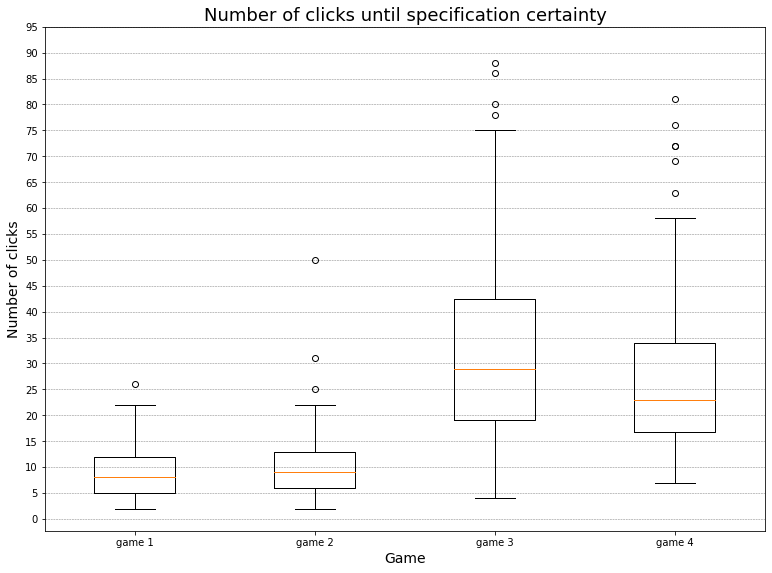

In [497]:
import matplotlib.pyplot as plt
game_data =[game_clicks[game1_score], game_clicks[game2_score], game_clicks[game3_score], game_clicks[game4_score]]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
 
bp = ax.boxplot(game_data)
plt.xticks([1, 2, 3, 4], ['game 1', 'game 2', 'game 3', 'game 4'])
plt.yticks(np.arange(0, 100, 5))

plt.xlabel("Game",size=14)
plt.ylabel("Number of clicks",size=14)
plt.title("Number of clicks until specification certainty", size=18)

ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
 
plt.show()


Possible analyses/figures: 
- Compare average model clicks until certainty to time until participants' "aha" moments (would only be comparable to participants that eventually inferred the correct specification). 
- Make the same plots of # of clicks to get first point vs. # of clicks to get second point and see how the can compare to participant data. 

Possible updates to the model:
- Add in noise when sampling hypotheses. 
- Play around with changing the weight of priors.
- Change such that once one hypothesis is found to be consistent, no other hypotheses are considered (assumption of only one method to score points). (**Note: actually doesn't seem like a good idea, could accept a more complicated hypothesis that is incorrect**).  Might need to find a way to better bias toward simpler hypotheses, or automatically rule hypotheses out quickly (e.g. maybe rule out all those more complicated...). Could potentially be solved by better weighting the priors.
- Once hypothesis is selected, try to change background color to color of hypothesis and test (don't only sample hypotheses that can be tested wit the current background color).